In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define depth of network and dimension of input data

In [3]:
L = 10
d = 100

# 1. Helper Functions

This function returns mean and variance of (max lw grad norm) / (min lw grad norm) while changing model width.

In [4]:
def compute_ratio(model_arc, width_range):
    lw_means = []
    lw_vars = []

    lw_ratio = []

    for c in width_range:
        print(f'width: {c}...')
        
        #try 100 times for each width to compute the mean and variance
        for _ in range(100):

            lw_norms = []

            #create model and define loss function
            model = model_arc(n_chan=c).to(device)
    #         crit = nn.BCEWithLogitsLoss() #BCEEWithLogitLoss basically gives the similar result with MSELoss, but it sometimes returns error when np.min(lw_norms) == 0
            crit = nn.MSELoss()

            #generate random input using normal distribution
            X = torch.from_numpy(np.random.normal(size=(10, d))).float().to(device)
            y = torch.ones(size=(10, 1)).float().to(device)
            for i, t in enumerate(y):
                if np.random.binomial(1, 0.5) == 1:
                    y[i] = 0
            
            #forward and backward computation
            pred = model(X)
            loss = crit(pred, y)
            loss.backward()

            #compute layer-wise gradient norms and append it to the list
            lw_norms.append(np.linalg.norm(model.fc_in.weight.grad.cpu()))
            for l in range(L):
                lw_norms.append(np.linalg.norm(model.fc_layers[l].weight.grad.cpu()))
            lw_norms.append(np.linalg.norm(model.fc_out.weight.grad.cpu()))

            #compute the ratio between maximum and minimum layer-wise gradient norm
            lw_ratio.append(np.max(lw_norms) / np.min(lw_norms))

        #compute mean and variance of ratio and save them to lists
        lw_means.append(np.mean(lw_ratio))
        lw_vars.append(np.var(lw_ratio))
        
    return lw_means, lw_vars

In [5]:
def plot_result(width_range, lw_means, lw_vars):
    plt.figure(figsize=(17, 5))

    plt.subplot(121)
    plt.plot(width_range, lw_means)
    plt.ylabel('(max grad) / (min grad)')
    plt.xlabel('width')
    plt.title('Mean ratio between maximum and minimum layer-wise gradient norm')

    plt.subplot(122)
    plt.plot(width_range, lw_vars)
    plt.ylabel('(max grad) / (min grad)')
    plt.xlabel('width')
    plt.title('Variance of ratio between maximum and minimum layer-wise gradient norm')

# 2. Simulation

### 2.1 Fully Connected Linear Network

In [6]:
class nn_model(nn.Module):
    def __init__(self, n_chan=10):
        super(nn_model, self).__init__()
        
        self.fc_in = nn.Linear(d, n_chan, bias=False)
        
        self.fc_layers = nn.ModuleList()
        
        for _ in range(L):
            self.fc_layers.append(nn.Linear(n_chan, n_chan, bias=False))
            
        self.fc_out = nn.Linear(n_chan, 1, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
        
    def forward(self, x):
        x = self.fc_in(x)
        
        for l in range(L):
            x = self.fc_layers[l](x)
        x = self.fc_out(x)
        return x

width: 10...
width: 30...
width: 50...
width: 70...
width: 90...
width: 110...
width: 130...
width: 150...
width: 170...
width: 190...
width: 210...
width: 230...
width: 250...
width: 270...
width: 290...
width: 310...
width: 330...
width: 350...
width: 370...
width: 390...
width: 410...
width: 430...
width: 450...
width: 470...
width: 490...


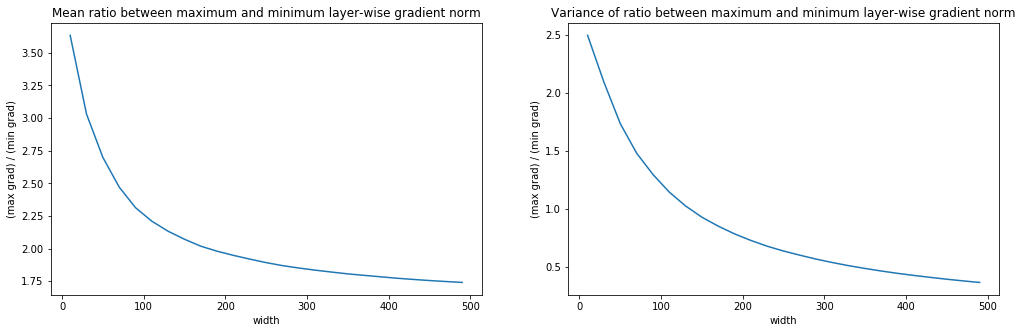

In [7]:
width_range = range(10, 501, 20)
lw_means, lw_vars = compute_ratio(nn_model, width_range)
plot_result(width_range, lw_means, lw_vars)

### 2.2 Fully Connected Linear Network with Batch Normalization

In [8]:
class nn_model_bn(nn.Module):
    def __init__(self, n_chan=10):
        super(nn_model_bn, self).__init__()
        
        self.fc_in = nn.Linear(d, n_chan, bias=False)
        self.bn_in = nn.BatchNorm1d(n_chan)
        
        self.fc_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for _ in range(L):
            self.fc_layers.append(nn.Linear(n_chan, n_chan, bias=False))
        for _ in range(L):
            self.batch_norms.append(nn.BatchNorm1d(n_chan))
            
        self.fc_out = nn.Linear(n_chan, 1, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
        
    def forward(self, x):
        x = self.fc_in(x)
        x = self.bn_in(x)
        
        for l in range(L):
            x = self.fc_layers[l](x)
            x = self.batch_norms[l](x)
        x = self.fc_out(x)
        return x

width: 10...
width: 30...
width: 50...
width: 70...
width: 90...
width: 110...
width: 130...
width: 150...
width: 170...
width: 190...
width: 210...
width: 230...
width: 250...
width: 270...
width: 290...
width: 310...
width: 330...
width: 350...
width: 370...
width: 390...
width: 410...
width: 430...
width: 450...
width: 470...
width: 490...


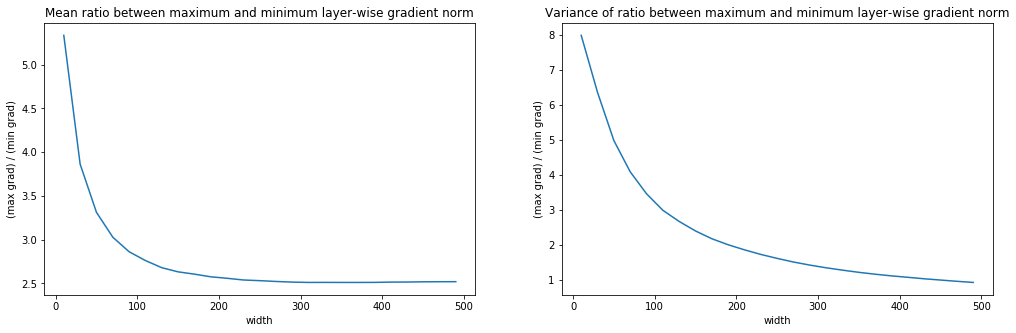

In [9]:
width_range = range(10, 501, 20)
lw_means, lw_vars = compute_ratio(nn_model_bn, width_range)
plot_result(width_range, lw_means, lw_vars)

### 2.3 Fully Connected ReLU Network with Batch Normalization

In [10]:
class nn_model_relu_bn(nn.Module):
    def __init__(self, n_chan=10):
        super(nn_model_relu_bn, self).__init__()
        
        self.fc_in = nn.Linear(d, n_chan, bias=False)
        self.bn_in = nn.BatchNorm1d(n_chan)
        
        self.fc_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for _ in range(L):
            self.fc_layers.append(nn.Linear(n_chan, n_chan, bias=False))
        for _ in range(L):
            self.batch_norms.append(nn.BatchNorm1d(n_chan))
            
        self.fc_out = nn.Linear(n_chan, 1, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
        
    def forward(self, x):
        x = self.fc_in(x)
        x = F.relu(self.bn_in(x))
        
        for l in range(L):
            x = self.fc_layers[l](x)
            x = F.relu(self.batch_norms[l](x))
        x = self.fc_out(x)
        return x

width: 10...
width: 30...
width: 50...
width: 70...
width: 90...
width: 110...
width: 130...
width: 150...
width: 170...
width: 190...
width: 210...
width: 230...
width: 250...
width: 270...
width: 290...
width: 310...
width: 330...
width: 350...
width: 370...
width: 390...
width: 410...
width: 430...
width: 450...
width: 470...
width: 490...


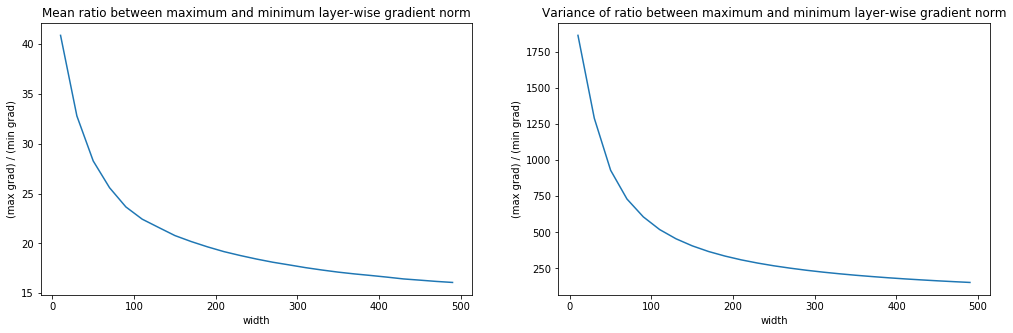

In [11]:
width_range = range(10, 501, 20)
lw_means, lw_vars = compute_ratio(nn_model_relu_bn, width_range)
plot_result(width_range, lw_means, lw_vars)